**Load Dependencies**


In [1]:
import tensorflow as tf
import numpy as np
import json
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Dense
from tensorflow.keras.layers import Flatten

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


**Load Marsyas MFCC Dataset**


In [2]:
file_path = "data/mfcc_gtzan10.json"

with open(file_path, "r") as f:
    data = json.load(f)

**Transforms Labels and MFCCs to Numpy Arrays**

In [4]:
X = np.array(data['mfcc'])
y = np.array(data['labels'])
print(X[0])


[[-2.12685546e+02  1.00718600e+02 -1.23222813e+01 ... -3.59266860e+00
  -1.15427554e+00 -3.71990146e+00]
 [-2.10629281e+02  1.03621303e+02 -1.16983593e+01 ... -5.39652393e+00
   2.20071144e+00 -3.11685376e+00]
 [-1.95409321e+02  1.04360651e+02 -1.85502341e-01 ... -1.08171604e+01
  -5.88807127e-01 -5.28410592e+00]
 ...
 [-1.24157705e+02  6.37352227e+01  2.11729392e+01 ... -1.65676625e+01
   1.37965153e+01 -2.31835349e+01]
 [-1.10560174e+02  6.07024768e+01  1.09157347e+00 ... -1.29631778e+01
   1.39237288e+01 -1.62484843e+01]
 [-1.14273381e+02  6.70723188e+01 -1.14650597e+01 ... -9.90297501e+00
   1.22151307e+01 -9.50313534e+00]]


**Split Data Set Into Training, Validation and Testing Sets**


In [5]:
TEST_SIZE = 0.25
VALIDATION_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)
# Subdivide Training Set Into Validation and Training Set 
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE)

X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [8]:
print(X_train[1].shape)
print(X_train[2].shape)

(130, 13, 1)
(130, 13, 1)


**Construct CNN** 

In [5]:

input_shape = (X_train.shape[1], X_train.shape[2],1)
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (1, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(256, (1, 1), activation='relu'))
model.add(MaxPool2D(pool_size=(1, 1), strides=(2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))

BATCH_SIZE = 10
EPOCHS = 50

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')

model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'] )

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 64)         16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 1, 64)         0

**Fit Model Over Training Set**


In [6]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=([reduce_lr,early_stopping])) 


Train on 5997 samples, validate on 2499 samples
Epoch 1/50
5997/5997 [==============================] - 5s 769us/sample - loss: 2.0358 - accuracy: 0.2558 - val_loss: 1.6840 - val_accuracy: 0.3846
Epoch 2/50
5997/5997 [==============================] - 3s 464us/sample - loss: 1.6645 - accuracy: 0.3914 - val_loss: 1.4877 - val_accuracy: 0.4470
Epoch 3/50
5997/5997 [==============================] - 3s 471us/sample - loss: 1.5111 - accuracy: 0.4416 - val_loss: 1.3806 - val_accuracy: 0.5018
Epoch 4/50
5997/5997 [==============================] - 3s 467us/sample - loss: 1.4222 - accuracy: 0.4762 - val_loss: 1.2803 - val_accuracy: 0.5502
Epoch 5/50
5997/5997 [==============================] - 3s 468us/sample - loss: 1.3588 - accuracy: 0.5093 - val_loss: 1.2085 - val_accuracy: 0.5690
Epoch 6/50
5997/5997 [==============================] - 3s 465us/sample - loss: 1.2867 - accuracy: 0.5409 - val_loss: 1.1651 - val_accuracy: 0.5806
Epoch 7/50
5997/5997 [==============================] - 3s 463us

**Evaluate Model Accuracy**


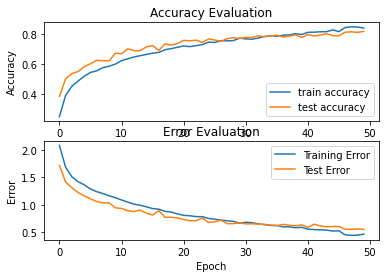

In [129]:

fig, axis = plt.subplots(2)

axis[0].plot(history.history['accuracy'], label="train accuracy")
axis[0].plot(history.history['val_accuracy'], label="test accuracy")
axis[0].set_ylabel("Accuracy")
axis[0].legend(loc="lower right")
axis[0].set_title("Accuracy Evaluation")

axis[1].plot(history.history['loss'], label="Training Error")
axis[1].plot(history.history['val_loss'], label="Test Error")
axis[1].set_ylabel("Error")
axis[1].set_xlabel("Epoch")
axis[1].legend(loc="upper right")
axis[1].set_title("Error Evaluation")

plt.show()



In [11]:
input = X_test[100]
input = input[np.newaxis, ...]
prediction = model.predict(input)
pred_index = np.argmax(prediction, axis=1)
print("target: {}, Predicted {}".format(y_test[100],pred_index))

target: 3, Predicted [3]


**Accuracy Score**

In [133]:

predictions = model.predict_classes(X_test)
print("Accuracy: {}".format(round(accuracy_score(y_test,predictions)*100,2)))


Accuracy: 81.87


**Confusion Matrix**


In [135]:
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix: \n", conf_matrix)
print("Classification Report: \n", classification_report(y_test, predictions))


Confusion Matrix: 
 [[234   0   9   5   1  12   4   0   5   4]
 [  1 247   3   0   0   6   0   1   0   0]
 [  9   0 173   2   0  12   1   7   6  17]
 [  3   2   2 219  12   0   3  10  11  13]
 [  5   0   0   7 209   3   6   9   7   2]
 [  2  11   7   1   0 205   1   1   3   1]
 [  3   0   2   1   6   0 236   0   2  11]
 [  0   0  12   3   3   0   0 202   6   8]
 [  1   0   8  13  23   2   0   7 168   5]
 [ 16   3  24  21   7   7  17   5  10 153]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       274
           1       0.94      0.96      0.95       258
           2       0.72      0.76      0.74       227
           3       0.81      0.80      0.80       275
           4       0.80      0.84      0.82       248
           5       0.83      0.88      0.86       232
           6       0.88      0.90      0.89       261
           7       0.83      0.86      0.85       234
           8       0.77      0.74    

**Observations:** We can observe that our model was very accurate at classifying classical music and exceeded human-accuracy for all genres except rock. That is understandable given its similarities with genres such as metal and pop. Reducing the number of segments extracted per audio track may have improved the general accuracy of the model. 

**Save Model**


In [136]:
MODEL_DIR = "./models/music_genre_cnn.hdf5"
print("Saving Model In: " + MODEL_DIR)
tf.keras.models.save_model(model,MODEL_DIR,overwrite=True)


Saving Model In: ./models/music_genre_cnn.hdf5
